## 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### 1.2 Remove Dodgy Images

In [2]:
import os
import time
import uuid
import cv2
import imghdr
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
IMAGES_PATH = os.path.join('data','images')
image_exts = ['jpeg','jpg','bmp','png']

In [4]:
for image in os.listdir(IMAGES_PATH):
    image_path = os.path.join(IMAGES_PATH, image)
    im = Image.open(image_path)
    rgb_im = im.convert('RGB')
    rgb_im.save(image_path)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        
        if tip not in image_exts:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)
    except Exception as e:
        print('Issue with image {}'.format(image_path))

Image not in ext list data\images\01-drowsiness-detection-feature.gif
Issue with image data\images\01-drowsiness-detection-feature.gif
Image not in ext list data\images\AI-based-Driver-Monitoring-System.webp
Image not in ext list data\images\Alzheimer_V_jpg--442x260-4g.webp
Image not in ext list data\images\ChronicFatigue.gif
Issue with image data\images\ChronicFatigue.gif
Image not in ext list data\images\df43de2-1275-7872-ce38-fd1be6e33_ezgif.com-resize_5_.gif
Issue with image data\images\df43de2-1275-7872-ce38-fd1be6e33_ezgif.com-resize_5_.gif


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Image not in ext list data\images\drowsy_but_awake-hero-Stocksy-464752.webp
Image not in ext list data\images\p391-f1.gif
Issue with image data\images\p391-f1.gif
Image not in ext list data\images\Python-Project-on-Driver-Drowsiness-Detection-System-video-vv3.gif
Issue with image data\images\Python-Project-on-Driver-Drowsiness-Detection-System-video-vv3.gif
Image not in ext list data\images\sleepy-drowsy.gif
Issue with image data\images\sleepy-drowsy.gif
Image not in ext list data\images\sleepy-drowsy2.gif
Issue with image data\images\sleepy-drowsy2.gif
Image not in ext list data\images\sleepy-face-sleepy.gif
Issue with image data\images\sleepy-face-sleepy.gif
Image not in ext list data\images\v4-460px-Avoid-Feeling-Drowsy-After-Lunch-Step-1-Version-4.jpg.webp


### 1.3 Annotate Images with LabelMe

In [5]:
!labelme

## 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [14]:
import tensorflow as tf
import cv2
import json
import numpy as np

### 2.2 Limit GPU Memory Growth

In [15]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [16]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Images into TF Data Pipeline

In [34]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [56]:
images = tf.data.Dataset.list_files('data\\images\\*', shuffle=False)
images = images.map(load_image)

### 2.4 View Raw Images with Matplotlib

In [53]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):    
    ax[idx].imshow(img.astype(image))
plt.show()

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [1101,1500,3], [batch]: [700,467,3] [Op:IteratorGetNext]

## 3. Partition Unaugmented Data

### 3.1 Manually Split Data Into Train Test and Val

### 3.2 Move the Matching Labels

In [34]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

## 4. Apply Image Augmentation on Images and Labels using Albumentattions

### 4.1 Setup Albumentations Transform Pipeline

In [14]:
import albumentations as alb

In [15]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),\
                         alb.HorizontalFlip(p=0.5),\
                         alb.RandomBrightnessContrast(p=0.2),\
                         alb.RandomGamma(p=0.2),\
                         alb.RGBShift(p=0.2),\
                         alb.VerticalFlip(p=0.5)],\
                         bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [16]:
img = cv2.imread(os.path.join('data','train','images','561ecb37-076f-11ee-ba3d-30de4b6761b7.jpg'))

In [17]:
img

array([[[250, 255, 254],
        [250, 255, 254],
        [250, 255, 254],
        ...,
        [ 77,  72,  99],
        [ 84,  76, 107],
        [ 84,  75, 108]],

       [[250, 255, 254],
        [250, 255, 254],
        [250, 255, 254],
        ...,
        [ 74,  68,  91],
        [ 82,  75, 102],
        [ 86,  79, 106]],

       [[250, 255, 254],
        [250, 255, 254],
        [250, 255, 254],
        ...,
        [ 67,  64,  79],
        [ 83,  77,  94],
        [ 93,  87, 104]],

       ...,

       [[ 63,  80,  93],
        [ 63,  79,  91],
        [ 67,  78,  86],
        ...,
        [ 22,  27,  26],
        [ 24,  29,  30],
        [ 22,  28,  27]],

       [[ 56,  86,  91],
        [ 58,  85,  89],
        [ 63,  83,  88],
        ...,
        [ 19,  28,  25],
        [ 21,  32,  30],
        [ 23,  34,  31]],

       [[ 51,  87,  87],
        [ 56,  87,  88],
        [ 60,  85,  87],
        ...,
        [ 18,  29,  26],
        [ 18,  29,  26],
        [ 14,  28,  24]]

In [18]:
with open(os.path.join('data','train','labels','561ecb37-076f-11ee-ba3d-30de4b6761b7.json'), 'r') as f:
    label = json.load(f)

In [21]:
label['shapes'][0]['points']

[[187.51824817518246, 3.5036496350365045],
 [616.3401101607631, 479.00000000000006]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [22]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [23]:
coords

[187.51824817518246, 3.5036496350365045, 616.3401101607631, 479.00000000000006]

In [24]:
coords = list(np.divide(coords, [640,480,640,480]))

In [25]:
coords

[0.2929972627737226,
 0.007299270072992718,
 0.9630314221261923,
 0.9979166666666668]

### 4.4 Apply Augmentations and View Results

In [32]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

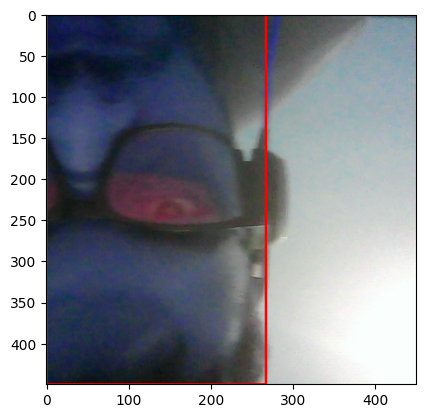

In [33]:
cv2.rectangle(augmented['image'],\
              #opencv expects tuple, rescaling the image to original size i.e. why multiplication
             tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),\
             tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),\
             #BGR format, thickness of rectangle
              (255,0,0), 2)
plt.imshow(augmented['image'])

## 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [39]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0
                
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to TensorFlow Dataset

In [40]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [41]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [42]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

## 6. Prepare Labels

### 6.1 Build Label Loading Function

In [43]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [44]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [45]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [47]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

## 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [48]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 780, 780, 840, 840)

### 7.2 Create Final Datasets (Images/ Labels)

In [49]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [50]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [51]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [53]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [54]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3127 , 0.296  , 0.705  , 0.8345 ],
        [0.2942 , 0.2568 , 0.68   , 0.803  ],
        [0.01122, 0.1915 , 0.5107 , 0.753  ],
        [0.01212, 0.     , 0.91   , 1.     ],
        [0.2913 , 0.2532 , 0.7793 , 0.785  ],
        [0.5693 , 0.1721 , 0.8647 , 0.563  ],
        [0.474  , 0.3381 , 0.9233 , 0.9253 ],
        [0.283  , 0.1515 , 0.687  , 0.7046 ]], dtype=float16))

### 7.3 View Images and Annotations

In [55]:
data_samples = train.as_numpy_iterator()

In [60]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


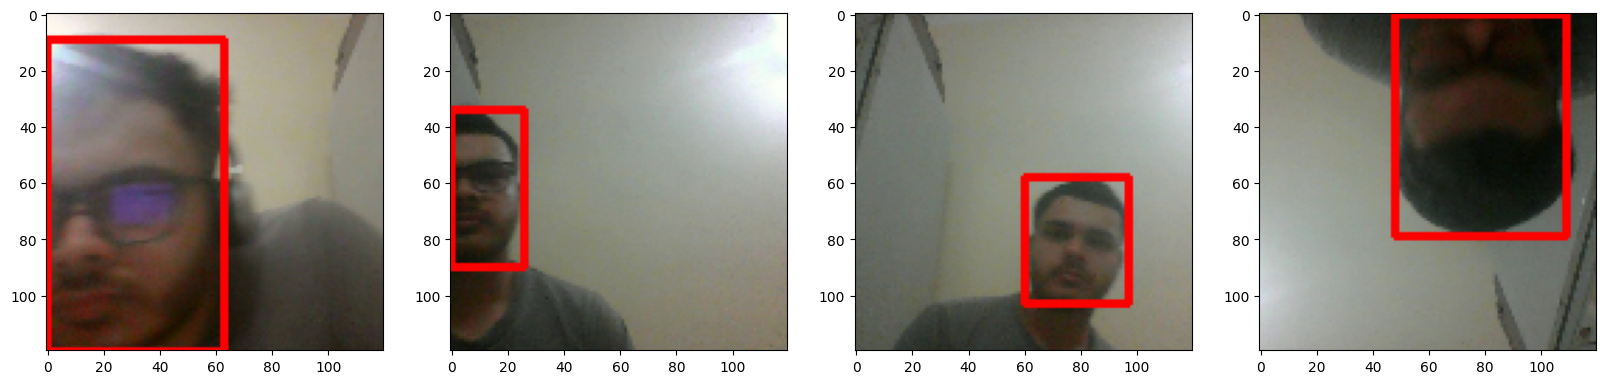

In [61]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    cv2.rectangle(sample_image,\
                 tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),\
                 tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                 (255,0,0),2)
    ax[idx].imshow(sample_image)

## 8. Build Deep Learning Model using the Functional API

### 8.1 Import Layers and Base Network

In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [66]:
vgg = VGG16(include_top=False)
## vgg16 is a classification model. so we are substituting the final layers as we require regression for bounding box

58889256/58889256 [==============================] - 6s 0us/step


In [67]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build Instance of Network

In [69]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)
    #CLassification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    #Regression Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

    

### 8.4 Test out Neural Network

In [70]:
facetracker = build_model()

In [71]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [72]:
X,y = train.as_numpy_iterator().next()

In [73]:
X.shape

(8, 120, 120, 3)

In [74]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [75]:
classes, coords

(array([[0.429274  ],
        [0.51025826],
        [0.4160123 ],
        [0.37524688],
        [0.46482033],
        [0.42983562],
        [0.4517943 ],
        [0.50732803]], dtype=float32),
 array([[0.446511  , 0.40129194, 0.42088345, 0.5805953 ],
        [0.46598753, 0.48304206, 0.37599987, 0.5874516 ],
        [0.46587124, 0.41106194, 0.39029816, 0.5984729 ],
        [0.5049748 , 0.42062363, 0.37247697, 0.6808548 ],
        [0.44725522, 0.4757588 , 0.36586982, 0.56608605],
        [0.44064292, 0.47790867, 0.33976302, 0.5585755 ],
        [0.4346047 , 0.3669588 , 0.3249931 , 0.52227205],
        [0.48579124, 0.43593326, 0.44574288, 0.58606744]], dtype=float32))

## 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [77]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [107]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

### 9.2 Create Localization Loss and Classification Loss

In [83]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2]-yhat[:,:2]))
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    return delta_coord + delta_size

In [84]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [86]:
localization_loss(y[1], coords).numpy()

3.9478054

In [88]:
classloss(y[0], classes).numpy()

0.8074114

In [89]:
regressloss(y[1], coords).numpy()

3.9478054

## 10. Train Neural Network

### 10.1 Create Custom Model Class

In [108]:
class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training = True)
            batch_classloss = self.closs(y[0], classes) #ytrue, ypred
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            total_loss = batch_localizationloss + 0.5*batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X,y = batch
        classes, coords =self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5*batch_classloss
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [109]:
model = FaceTracker(facetracker)

In [110]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [104]:
logdir = 'logs'

In [111]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [112]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
473/473 [==============================] - 2023s 4s/step - total_loss: 0.1524 - class_loss: 0.0315 - regress_loss: 0.1367 - val_total_loss: 0.0451 - val_class_loss: 6.1613e-05 - val_regress_loss: 0.0450
Epoch 2/5
473/473 [==============================] - 1976s 4s/step - total_loss: 0.0671 - class_loss: 0.0195 - regress_loss: 0.0574 - val_total_loss: 0.0278 - val_class_loss: 0.0020 - val_regress_loss: 0.0268
Epoch 3/5
473/473 [==============================] - 1971s 4s/step - total_loss: 0.0734 - class_loss: 0.0198 - regress_loss: 0.0635 - val_total_loss: 0.0699 - val_class_loss: 3.2359e-05 - val_regress_loss: 0.0699
Epoch 4/5
473/473 [==============================] - 2988s 6s/step - total_loss: 0.0603 - class_loss: 0.0134 - regress_loss: 0.0536 - val_total_loss: 0.0518 - val_class_loss: 0.0109 - val_regress_loss: 0.0464
Epoch 5/5
473/473 [==============================] - 2707s 6s/step - total_loss: 0.0387 - class_loss: 0.0089 - regress_loss: 0.0342 - val_total_loss: 0.0091

### 10.3 Plot Performance

In [113]:
hist.history

{'total_loss': [1.4373564720153809,
  0.8901769518852234,
  0.014532934874296188,
  0.004673164337873459,
  0.005690145306289196],
 'class_loss': [0.8011865019798279,
  0.4723168909549713,
  1.794153831724543e-05,
  3.549658504198305e-05,
  0.0031177166383713484],
 'regress_loss': [1.0367631912231445,
  0.6540185213088989,
  0.014523964375257492,
  0.004655416123569012,
  0.0041312868706882],
 'val_total_loss': [0.04507707804441452,
  0.027830246835947037,
  0.06989192217588425,
  0.05184142664074898,
  0.00907810963690281],
 'val_class_loss': [6.161264900583774e-05,
  0.00199944619089365,
  3.235931944800541e-05,
  0.010942568071186543,
  5.774235432909336e-06],
 'val_regress_loss': [0.04504626989364624,
  0.0268305242061615,
  0.06987573951482773,
  0.046370141208171844,
  0.009075222536921501]}

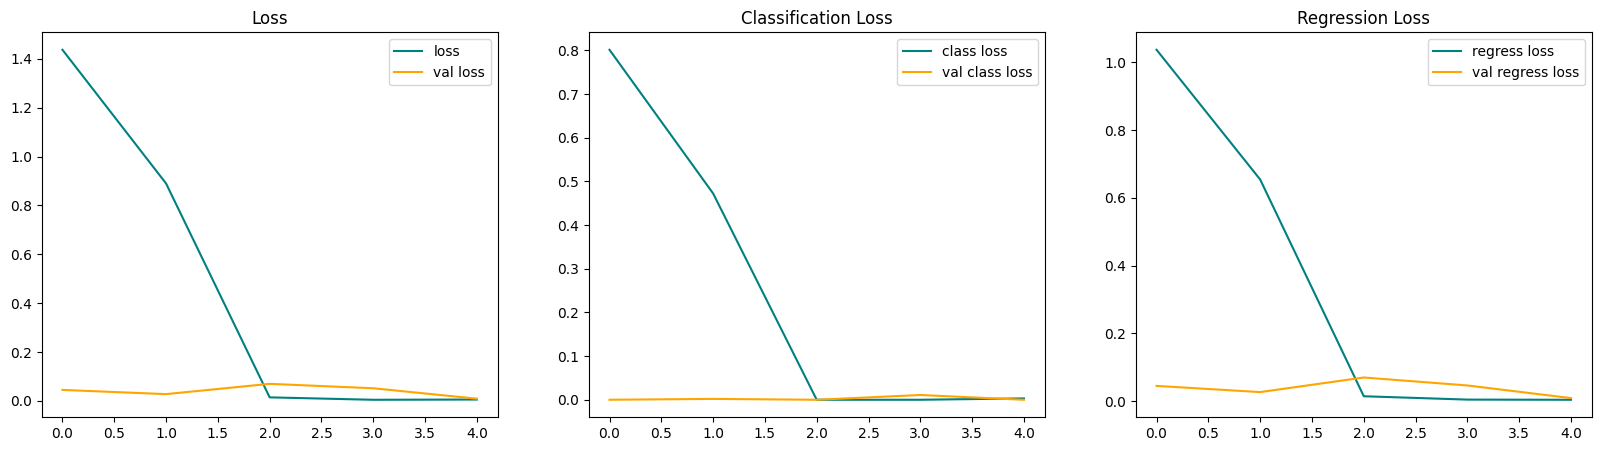

In [114]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [115]:
test_data = test.as_numpy_iterator()

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


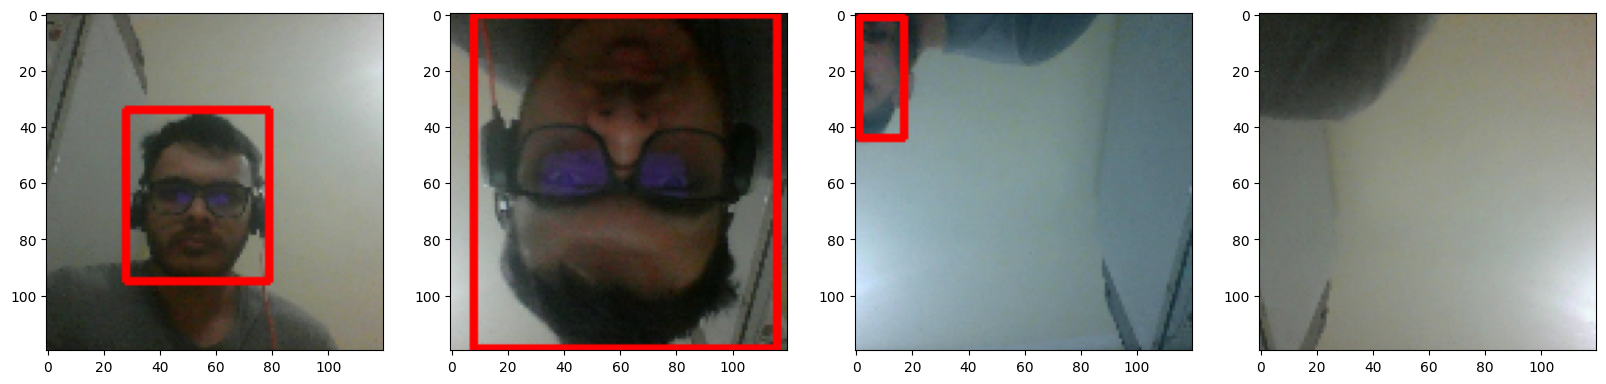

In [125]:
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image,\
                     tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),\
                     tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),\
                     (255,0,0),2)
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [126]:
from tensorflow.keras.models import load_model

In [127]:
facetracker.save('facetracker.h5')

In [128]:
#facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [133]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        cv2.rectangle(frame,\
                     tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),\
                     tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),\
                     (255,0,0),2)
        cv2.rectangle(frame,\
                     tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0,-30])),\
                     tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [80, 0])),\
                     (255,0,0),-1)
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0, -5])),\
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2, cv2.LINE_AA)
    cv2.imshow('EyeTrack', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 191ms/step
